In [15]:
from datetime import datetime
import os
import requests
import bz2
import xarray as xr
import metpy
import pandas as pd
from utils import * 
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from matplotlib.colors import BoundaryNorm
from multiprocessing import Pool, cpu_count
from functools import partial

projection = euratl


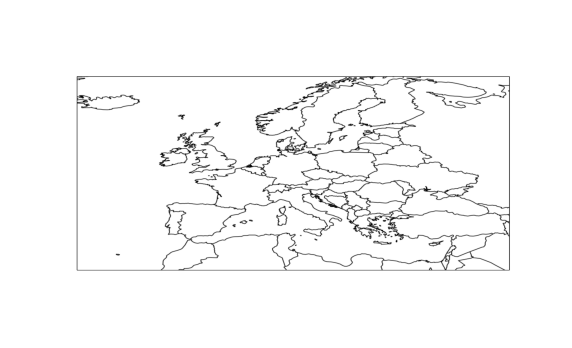

In [22]:
fig = plt.figure(figsize=(figsize_x, figsize_y))
ax = get_projection_cartopy(plt, 'euratl', regions=False, compute_projection=False)
plt.savefig('euratl_background.png', bbox_inches='tight')

In [ ]:
# takes long time 
dset = get_dset(vars_2d=['t_2m'], f_times=list(np.arange(1, 79)) )

In [90]:
def subset_arrays(arrs, proj):
    """Given an input projection created with basemap or cartopy subset the input arrays 
    on the boundaries"""
    proj_options = proj_defs[proj]
    if type(arrs) is list:
        out = []
        for arr in arrs:
            out.append(arr.sel(latitude=slice(proj_options['extents'][2], proj_options['extents'][3]),
                                longitude=slice(proj_options['extents'][0], proj_options['extents'][1])))
    else:
        return arrs.sel(latitude=slice(proj_options['extents'][2], proj_options['extents'][3]),
                                longitude=slice(proj_options['extents'][0], proj_options['extents'][1]))

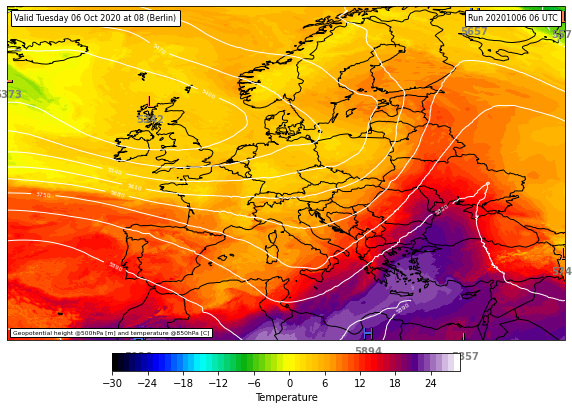

In [6]:
dset = get_dset(vars_3d=['t@850','fi@500'])

variable_name = 'gph_t_850'
projection='euratl'

dset = get_dset(vars_3d=['t@850','fi@500']).squeeze()
dset = subset_arrays(dset, projection)
cum_hour =  dset.step.values.astype(int)
time = pd.to_datetime(dset.valid_time.values)
run = dset.time.dt.strftime('%Y%m%d%H').values

temp_850 = dset['t'] - 273.15
z_500 = dset['z']
gph_500 = mpcalc.geopotential_to_height(z_500)
gph_500 = xr.DataArray(gph_500.magnitude, coords=z_500.coords,
                       attrs={'standard_name': 'geopotential height',
                              'units': gph_500.units})

levels_temp = np.arange(-30., 30., 1.)
levels_gph = np.arange(4700., 6000., 70.)

cmap = get_colormap('temp')

fig = plt.figure(figsize=(figsize_x, figsize_y))

lon, lat = get_coordinates(temp_850)
lon2d, lat2d = np.meshgrid(lon, lat)

ax = get_projection_cartopy(plt, projection, compute_projection=True)

# Build the name of the output image
filename = projection + '_' + variable_name + '_%s_%03d.png' % (run,
                                                              cum_hour)

if projection == 'euratl':
    norm = BoundaryNorm(levels_temp, ncolors=cmap.N)
    cs = ax.pcolormesh(lon2d, lat2d, temp_850, cmap=cmap, norm=norm)
else:
    cs = ax.contourf(lon2d, lat2d, temp_850, extend='both', cmap=cmap, levels=levels_temp)

c = ax.contour(lon2d, lat2d, gph_500, levels=levels_gph, colors='white', linewidths=1.)

labels = ax.clabel(c, c.levels, inline=True, fmt='%4.0f', fontsize=6)

maxlabels = plot_maxmin_points(ax, lon, lat, gph_500,
                               'max', 80, symbol='H', color='royalblue', random=True)
minlabels = plot_maxmin_points(ax, lon, lat, gph_500,
                               'min', 80, symbol='L', color='coral', random=True)

an_fc = annotation_forecast(ax, time)
an_var = annotation(
    ax, 'Geopotential height @500hPa [m] and temperature @850hPa [C]', loc='lower left', fontsize=6)
an_run = annotation_run(ax, time)

plt.colorbar(cs, orientation='horizontal',
             label='Temperature', pad=0.03, fraction=0.04)

plt.savefig(filename, dpi=150, bbox_inches='tight')

In [13]:
args = dict(filenames=filename, projection=projection, levels_temp=levels_temp,
                cmap=cmap, lon2d=lon2d, lat2d=lat2d, lon=lon, lat=lat, temp_850=temp_850.values,
                gph_500=gph_500.values, levels_gph=levels_gph, time=time)

In [168]:
from multiprocessing import Pool, cpu_count
from functools import partial

In [18]:
def plot_vars(projection):
    # The one employed for the figure name when exported
    variable_name = 'gph_t_850'
    # Build the name of the output image
    run_string, _ = get_run()
    f_steps = list(range(0, 79)) + list(range(81, 121, 3))

    filenames = ['/tmp/' + projection + '_' + variable_name +
                 '_%s_%03d.png' % (run_string, f_step) for f_step in f_steps]
    test_filenames = [os.path.exists(f) for f in filenames]

#     if all(test_filenames):  # means the files already exist
#         return filenames

    # otherwise do the plots
    dset = get_dset(vars_3d=['t@850', 'fi@500'], f_times=f_steps).squeeze()
    dset = subset_arrays(dset, projection)
    time = pd.to_datetime(dset.valid_time.values)
    cum_hour = dset.step.values.astype(int)

    temp_850 = dset['t'] - 273.15
    z_500 = dset['z']
    gph_500 = mpcalc.geopotential_to_height(z_500)
    gph_500 = xr.DataArray(gph_500.magnitude, coords=z_500.coords,
                           attrs={'standard_name': 'geopotential height',
                                  'units': gph_500.units})

    levels_temp = np.arange(-30., 30., 1.)
    levels_gph = np.arange(4700., 6000., 70.)

    lon, lat = get_coordinates(temp_850)
    lon2d, lat2d = np.meshgrid(lon, lat)

    cmap = get_colormap('temp')

    args = dict(filenames=filenames, projection=projection, levels_temp=levels_temp,
                cmap=cmap, lon2d=lon2d, lat2d=lat2d, lon=lon, lat=lat, temp_850=temp_850.values,
                gph_500=gph_500.values, levels_gph=levels_gph, time=time)

    single_plot_param = partial(single_plot, **args)
    iterator = range(0, len(f_steps))
    pool = Pool(cpu_count())
    results = pool.map(single_plot_param, iterator)
    pool.close()
    pool.join()


def single_plot(f_step, **args):
    filename = args['filenames'][f_step]
    
#     if os.path.exists(filename):
#         continue

    fig = plt.figure(figsize=(figsize_x, figsize_y))
    ax = plt.gca()
    ax = get_projection_cartopy(
        plt, args['projection'], compute_projection=True)

    if args['projection'] == 'euratl':
        norm = BoundaryNorm(args['levels_temp'], ncolors=args['cmap'].N)
        cs = ax.pcolormesh(args['lon2d'], args['lat2d'], args['temp_850'][f_step],
                           cmap=args['cmap'], norm=norm)
    else:
        cs = ax.contourf(args['lon2d'], args['lat2d'], args['temp_850'][f_step], extend='both',
                         cmap=args['cmap'], levels=args['levels_temp'])

    c = ax.contour(args['lon2d'], args['lat2d'], args['gph_500'][f_step],
                   levels=args['levels_gph'], colors='white', linewidths=1.)

    labels = ax.clabel(c, c.levels, inline=True, fmt='%4.0f', fontsize=6)

    maxlabels = plot_maxmin_points(ax, args['lon'], args['lat'], args['gph_500'][f_step],
                                   'max', 80, symbol='H', color='royalblue', random=True)
    minlabels = plot_maxmin_points(ax, args['lon'], args['lat'], args['gph_500'][f_step],
                                   'min', 80, symbol='L', color='coral', random=True)

    an_fc = annotation_forecast(ax, args['time'][f_step])
    an_var = annotation(
        ax, 'Geopotential height @500hPa [m] and temperature @850hPa [C]', loc='lower left', fontsize=6)
    an_run = annotation_run(ax, args['time'][0])

    plt.colorbar(cs, orientation='horizontal',
                 label='Temperature', pad=0.03, fraction=0.04)

    plt.savefig(filename, **options_savefig)
    plt.clf()
    print('Done '+filename)

In [19]:
plot_vars('it')

Done /tmp/it_gph_t_850_2020100606_003.png
Done /tmp/it_gph_t_850_2020100606_000.png
Done /tmp/it_gph_t_850_2020100606_006.pngDone /tmp/it_gph_t_850_2020100606_009.png

Done /tmp/it_gph_t_850_2020100606_012.png
Done /tmp/it_gph_t_850_2020100606_015.png
Done /tmp/it_gph_t_850_2020100606_018.png
Done /tmp/it_gph_t_850_2020100606_021.png
Done /tmp/it_gph_t_850_2020100606_004.png
Done /tmp/it_gph_t_850_2020100606_001.png
Done /tmp/it_gph_t_850_2020100606_010.png
Done /tmp/it_gph_t_850_2020100606_007.png
Done /tmp/it_gph_t_850_2020100606_013.png
Done /tmp/it_gph_t_850_2020100606_016.png
Done /tmp/it_gph_t_850_2020100606_019.png
Done /tmp/it_gph_t_850_2020100606_022.png
Done /tmp/it_gph_t_850_2020100606_002.png
Done /tmp/it_gph_t_850_2020100606_008.png
Done /tmp/it_gph_t_850_2020100606_005.png
Done /tmp/it_gph_t_850_2020100606_011.png
Done /tmp/it_gph_t_850_2020100606_017.png
Done /tmp/it_gph_t_850_2020100606_014.png
Done /tmp/it_gph_t_850_2020100606_020.png
Done /tmp/it_gph_t_850_2020100606_